# Техническое задание к проекту М1

# 1. Общая информация и цель проекта

В этом проекте предполагается работа с датасетом из открытого источника. Вам потребуется разработать модель машинного обучения, а также подготовить библиотеку и интерфейс к ней для предсказания на тестовой выборке. В начале проекта вам будет доступен обучающий датасет и тестовый датасет, не содержащий правильных ответов. Метрика на тестовом датасете будет измерена в ходе проверки работы. Также вам будет доступен скрипт, с помощью которого будет измеряться финальная метрика вашей модели.

# 2. Задачи проекта

Предполагается, что в ходе работы над проектом будут решены следующие задачи:
Исследование датасета (предполагается поиск дополнительной информации для лучшего понимания природы данных)
Предобработка данных. Будьте внимательны: в данных могут быть бесполезные признаки, сильно скорелированные признаки а также косвенные утечки целевого признака. Некоторые колонки потребуется преобразовать к нужному типу данных.
Обучение модели
Подготовка предсказания на тестовой выборке. Обратите внимание. Файл предсказаний должен быть в csv формате и содержать 2 столбца: “id” и “prediction”. 
Подготовка скриптов и библиотеки для обработки данных и предсказания на тестовой выборке
Написание инструмента для тестирования
Оформление документации

# 3. Описание исходных данных

Данные пациентов для предсказания риска сердечных приступов
id  - id
Антропометрические параметры (вес, возраст, рост)
Привычки (курение, качество сна и т.д)
Давление
Наличие хронических заболеваний
Биохимия крови
Таргет - высокий или низкий риск поражения сердца
Train
Test
Скрипт, которым будет тестироваться качество вашей модели

# 4. Используемая метрика оценки качества и сравнения моделей

В ходе анализа датасетов вам предстоит самостоятельно определить наилучшую метрику оценки качества модели и обосновать ваш выбор.

# 5. Стек

Python (ООП)
Pandas
numpy
Scikitlearn
CatBoost
FastAPI
HTML

# 6. Таймлайн проекта

Проект длится 2 недели и включает в себя:
Установочную встречу
Семинар по FastAPI + QA-сессия
Финальная встреча


# 7. Результат

В результате у вас должно получиться приложение на FastAPI (или аналогичном фреймворке) которое принимает на вход путь к csv файлу тестовой выборки, выполняет предсказание (например, путем POST запроса к сервису) и возвращает ответ в формате JSON. Допускается для тестирования написать скрипт, который посылает запрос к запущенному ранее приложению, либо реализовать веб-интерфейс. 
Обратите внимание, что оцениваться будет помимо качества модели структурированность, понятность и чистота кода, архитектура приложения. Обязательным является использование ООП, то есть составные части приложения должны быть реализованы в виде классов. Проект должен быть оформлен в виде репозитория на github (gitlab), должна быть написана документация к сервису с описанием для пользователя и описанием классов и методов в приложении, как если бы далее ваш проект вы передавали пользователю. В jupiter ноутбуках могут быть только исследования и эксперименты, если демонстрацию результатов работы приложения вы также выносите в ноутбук - то кода приложения в ноутбуке быть не должно: он должен импортироваться в качестве внешних модулей.
Формат сдачи работы
В репозитории должны быть:
Jupiter Notebook с исследованием, обучением моделей и выводами
Код вашего приложения
Предсказание на тестовой выборке в требуемом формате
Инструкция по запуску вашего приложения ИЛИ Jupiter Notebook с демонстрацией работы приложения ИЛИ выступление на финальной встрече где вы продемонстрируете работу приложения вживую
Критерии оценки
Исследование и результаты обучения моделей
Метрика на тестовой выборке (измеряется при проверке)
Чистота кода и структурированность кода
Оформление репозитория
Воспроизводимость результатов


## Импорты, загрузка данных

### устаналиваем нужное

In [1]:
!pip install phik -q 
# !pip install optuna -q
# !pip install optuna-integration[sklearn] -q нужна ли тут optuna?
!pip install --upgrade shap -q
!pip install --upgrade scikit-learn -q # изначально работает на 1.6.1
# !pip install scipy -q - статистика пока тут не нужна

In [2]:
!pip install catboost -q

### импортируем нужное

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# from scipy import stats - пока вроде не надо
import phik

import sklearn
from sklearn.model_selection import train_test_split

# загружаем класс pipeline
from sklearn.pipeline import Pipeline

# загружаем классы для подготовки данных
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# загружаем класс для работы с пропусками
from sklearn.impute import SimpleImputer

# загружаем функцию для работы с метриками
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# импортируем класс RandomizedSearchCV и Optuna
from sklearn.model_selection import RandomizedSearchCV
#from optuna.integration import OptunaSearchCV - пока без нее

# загружаем нужные модели
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

import shap

In [4]:
from catboost import CatBoostClassifier

In [5]:
import time # для возможной оптимизации, чтобы видеть сколько времени занимают некоторые процессы (в основном обучение)

In [6]:
import joblib # для сохранения модели

### объявляем константы

In [7]:
RANDOM_STATE = 42
VALID_SIZE = 0.25

### Загрузка данных

In [8]:
df_train = pd.read_csv ('https://drive.google.com/uc?export=download&id=1QYkOGKlHtugjJcccN7UhwPAvfsfyck7C')

In [9]:
df_test = pd.read_csv ('https://drive.google.com/uc?export=download&id=1qJduj_-_nWCNhfTdICReepAbUs8OHC_Y')

In [10]:
df_train.head()

Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
0           0  0.359551     0.732143    0.074244       1.0             1.0   
1           1  0.202247     0.325000    0.047663       1.0             1.0   
2           2  0.606742     0.860714    0.055912       1.0             0.0   
3           3  0.730337     0.007143    0.053162       0.0             0.0   
4           4  0.775281     0.757143    0.021998       0.0             0.0   

   Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  ...  \
0      1.0      1.0                  1.0                 0.535505  ...   
1      0.0      0.0                  1.0                 0.068690  ...   
2      1.0      1.0                  1.0                 0.944001  ...   
3      1.0      0.0                  1.0                 0.697023  ...   
4      1.0      0.0                  1.0                 0.412878  ...   

   Physical Activity Days Per Week  Sleep Hours Per Day  \
0                              3.0             0.333333   
1                              3.0             0.833333   
2                              2.0             1.000000   
3                              0.0             0.333333   
4                              5.0             1.000000   

   Heart Attack Risk (Binary)  Blood sugar     CK-MB  Troponin  Gender  \
0                         0.0     0.227018  0.048229  0.036512    Male   
1                         0.0     0.150198  0.017616  0.000194  Female   
2                         0.0     0.227018  0.048229  0.036512  Female   
3                         1.0     0.227018  0.048229  0.036512  Female   
4                         1.0     0.227018  0.048229  0.036512    Male   

   Systolic blood pressure  Diastolic blood pressure    id  
0                 0.212903                  0.709302  2664  
1                 0.412903                  0.569767  9287  
2                 0.238710                  0.220930  5379  
3                 0.348387                  0.267442  8222  
4                 0.619355                  0.441860  4047  

[5 rows x 28 columns]

In [11]:
df_test.head()

Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
0           0  0.494382     0.264286    0.062328       0.0             1.0   
1           1  0.224719     0.953571    0.082493       1.0             0.0   
2           2  0.629213     0.092857    0.064161       0.0             1.0   
3           3  0.460674     0.567857    0.055912       1.0             1.0   
4           4  0.719101     0.485714    0.022915       1.0             0.0   

   Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  ...  \
0      1.0      1.0                  1.0                 0.361618  ...   
1      0.0      1.0                  0.0                 0.996483  ...   
2      1.0      1.0                  0.0                 0.995561  ...   
3      1.0      1.0                  1.0                 0.437277  ...   
4      1.0      0.0                  1.0                 0.514920  ...   

   Triglycerides  Physical Activity Days Per Week  Sleep Hours Per Day  \
0       0.306494                              1.0             0.333333   
1       0.087013                              0.0             0.166667   
2       0.205195                              7.0             1.000000   
3       0.163636                              0.0             0.666667   
4       0.580519                              5.0             0.000000   

   Blood sugar     CK-MB  Troponin  Gender  Systolic blood pressure  \
0     0.227018  0.048229  0.036512    Male                 0.283871   
1     0.227018  0.048229  0.036512  Female                 0.703226   
2     0.102767  0.002666  0.088455    Male                 0.458065   
3     0.203557  0.056390  0.271774  Female                 0.741935   
4     0.227018  0.048229  0.036512    Male                 0.412903   

   Diastolic blood pressure    id  
0                  0.372093  7746  
1                  0.441860  4202  
2                  0.779070  6632  
3                  0.255814  4639  
4                  0.395349  4825  

[5 rows x 27 columns]

### Скрипт, которым будет тестироваться качество модели

import pandas as pd
from sklearn.metrics import classification_report
import argparse


def main(args):
    corr_df = pd.read_csv(args.correct, index_col=0)
    stud_df = pd.read_csv(args.student, index_col=0)
    assert "prediction" in list(stud_df.columns)
    assert len(stud_df) == len(corr_df)
    print(classification_report(corr_df["prediction"], stud_df["prediction"]))

if __name__ == "__main__":
    parser = argparse.ArgumentParser(description="test script")
    parser.add_argument("--student", type=str, required=True, help="path to students answer")
    parser.add_argument("--correct", type=str, default="correct_answers.csv", help="path to correct answers")
    arguments = parser.parse_args()
    main(arguments)


## Предобработка данных

### Удаляем ненужные столбцы:

In [12]:
df_train = df_train.drop('Unnamed: 0', axis = 1)
df_test = df_test.drop('Unnamed: 0', axis = 1)

### Проверяем дубликаты:

In [13]:
df_list = [df_test, df_train]

In [14]:
for df in df_list:
    df.info()
    print('\nДубликаты:', df.duplicated().sum())
    print('\n')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              966 non-null    float64
 1   Cholesterol                      966 non-null    float64
 2   Heart rate                       966 non-null    float64
 3   Diabetes                         935 non-null    float64
 4   Family History                   935 non-null    float64
 5   Smoking                          935 non-null    float64
 6   Obesity                          935 non-null    float64
 7   Alcohol Consumption              935 non-null    float64
 8   Exercise Hours Per Week          966 non-null    float64
 9   Diet                             966 non-null    int64  
 10  Previous Heart Problems          935 non-null    float64
 11  Medication Use                   935 non-null    float64
 12  Stress Level          

Дубликатов нет, есть много пробелов. 

Так как их количество относительно датасета невелико, считаю, что он не пострадает при их удалении. 


df_train = df_train.sort_values('id')
df_test = df_test.sort_values('id')

display(df_train['id'])
display(df_test['id'])

### Удаляем пропуски:

Перед тем как удалить данные, посмотрим что в них содержится, так как может пропуск несущественен.

In [15]:
with pd.option_context('display.max_columns', None):
    display(df_train[df_train.isna().any(axis=1)])

Age  Cholesterol  Heart rate  Diabetes  Family History  Smoking  \
16    0.449438      0.49978    0.063245       NaN             NaN      NaN   
90    0.370787      0.49978    0.066911       NaN             NaN      NaN   
92    0.629213      0.49978    0.073327       NaN             NaN      NaN   
185   0.516854      0.49978    0.045830       NaN             NaN      NaN   
188   0.269663      0.49978    0.035747       NaN             NaN      NaN   
...        ...          ...         ...       ...             ...      ...   
8461  0.719101      0.49978    0.049496       NaN             NaN      NaN   
8509  0.651685      0.49978    0.036664       NaN             NaN      NaN   
8536  0.651685      0.49978    0.054079       NaN             NaN      NaN   
8619  0.606742      0.49978    0.059578       NaN             NaN      NaN   
8639  0.629213      0.49978    0.057745       NaN             NaN      NaN   

      Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  \
16        NaN                  NaN                  0.50211     3   
90        NaN                  NaN                  0.50211     3   
92        NaN                  NaN                  0.50211     3   
185       NaN                  NaN                  0.50211     3   
188       NaN                  NaN                  0.50211     3   
...       ...                  ...                      ...   ...   
8461      NaN                  NaN                  0.50211     3   
8509      NaN                  NaN                  0.50211     3   
8536      NaN                  NaN                  0.50211     3   
8619      NaN                  NaN                  0.50211     3   
8639      NaN                  NaN                  0.50211     3   

      Previous Heart Problems  Medication Use  Stress Level  \
16                        NaN             NaN           NaN   
90                        NaN             NaN           NaN   
92                        NaN             NaN           NaN   
185                       NaN             NaN           NaN   
188                       NaN             NaN           NaN   
...                       ...             ...           ...   
8461                      NaN             NaN           NaN   
8509                      NaN             NaN           NaN   
8536                      NaN             NaN           NaN   
8619                      NaN             NaN           NaN   
8639                      NaN             NaN           NaN   

      Sedentary Hours Per Day    Income       BMI  Triglycerides  \
16                    0.49992  0.494889  0.494774       0.503603   
90                    0.49992  0.494889  0.494774       0.503603   
92                    0.49992  0.494889  0.494774       0.503603   
185                   0.49992  0.494889  0.494774       0.503603   
188                   0.49992  0.494889  0.494774       0.503603   
...                       ...       ...       ...            ...   
8461                  0.49992  0.494889  0.494774       0.503603   
8509                  0.49992  0.494889  0.494774       0.503603   
8536                  0.49992  0.494889  0.494774       0.503603   
8619                  0.49992  0.494889  0.494774       0.503603   
8639                  0.49992  0.494889  0.494774       0.503603   

      Physical Activity Days Per Week  Sleep Hours Per Day  \
16                                NaN             0.504621   
90                                NaN             0.504621   
92                                NaN             0.504621   
185                               NaN             0.504621   
188                               NaN             0.504621   
...                               ...                  ...   
8461                              NaN             0.504621   
8509                              NaN             0.504621   
8536                              NaN             0.504621   
8619                              NaN             0

как видно пропуски в большом количестве значимых столбцов, поэтому эти данные не годятся для последующей работы.

In [16]:
df_test = df_test.dropna(axis=0)

In [17]:
df_train = df_train.dropna(axis=0)

In [18]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 935 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              935 non-null    float64
 1   Cholesterol                      935 non-null    float64
 2   Heart rate                       935 non-null    float64
 3   Diabetes                         935 non-null    float64
 4   Family History                   935 non-null    float64
 5   Smoking                          935 non-null    float64
 6   Obesity                          935 non-null    float64
 7   Alcohol Consumption              935 non-null    float64
 8   Exercise Hours Per Week          935 non-null    float64
 9   Diet                             935 non-null    int64  
 10  Previous Heart Problems          935 non-null    float64
 11  Medication Use                   935 non-null    float64
 12  Stress Level          

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8442 entries, 0 to 8684
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8442 non-null   float64
 1   Cholesterol                      8442 non-null   float64
 2   Heart rate                       8442 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8442 non-null   float64
 9   Diet                             8442 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level        

## Исследовательский анализ данных (EDA)

### Описание признаков

Поскольку в условии задания не было описания всех признаков, то попытаюсь понять, что за данные представлены в таблицах:

Изначально дано: 

id  - id пациаента

Антропометрические параметры (вес, возраст, рост)

Привычки (курение, качество сна и т.д)

Давление

Наличие хронических заболеваний

Биохимия крови

Таргет - высокий или низкий риск поражения сердца

In [20]:
with pd.option_context('display.max_columns', None):
    display(df_train)

Age  Cholesterol  Heart rate  Diabetes  Family History  Smoking  \
0     0.359551     0.732143    0.074244       1.0             1.0      1.0   
1     0.202247     0.325000    0.047663       1.0             1.0      0.0   
2     0.606742     0.860714    0.055912       1.0             0.0      1.0   
3     0.730337     0.007143    0.053162       0.0             0.0      1.0   
4     0.775281     0.757143    0.021998       0.0             0.0      1.0   
...        ...          ...         ...       ...             ...      ...   
8680  0.359551     0.357143    0.040330       1.0             0.0      1.0   
8681  0.516854     0.832143    0.036664       1.0             1.0      1.0   
8682  0.471910     0.067857    0.023831       1.0             0.0      1.0   
8683  0.595506     0.000000    0.075160       0.0             1.0      1.0   
8684  0.292135     0.342857    0.021082       0.0             1.0      1.0   

      Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  \
0         1.0                  1.0                 0.535505     1   
1         0.0                  1.0                 0.068690     2   
2         1.0                  1.0                 0.944001     2   
3         0.0                  1.0                 0.697023     0   
4         0.0                  1.0                 0.412878     1   
...       ...                  ...                      ...   ...   
8680      1.0                  1.0                 0.926662     2   
8681      1.0                  1.0                 0.455572     2   
8682      0.0                  1.0                 0.076336     2   
8683      0.0                  1.0                 0.371759     2   
8684      1.0                  0.0                 0.567079     0   

      Previous Heart Problems  Medication Use  Stress Level  \
0                         1.0             0.0           8.0   
1                         1.0             0.0           9.0   
2                         1.0             1.0           6.0   
3                         0.0             1.0           3.0   
4                         0.0             0.0           8.0   
...                       ...             ...           ...   
8680                      1.0             0.0           6.0   
8681                      1.0             1.0           8.0   
8682                      0.0             1.0          10.0   
8683                      0.0             0.0           9.0   
8684                      0.0             0.0           9.0   

      Sedentary Hours Per Day    Income       BMI  Triglycerides  \
0                    0.225704  0.105948  0.459176       0.979221   
1                    0.289923  0.164217  0.117053       0.515584   
2                    0.550133  0.598745  0.373574       0.012987   
3                    0.330962  0.077605  0.049735       0.131169   
4                    0.524600  0.341960  0.830405       0.070130   
...                       ...       ...       ...            ...   
8680                 0.184825  0.412145  0.292379       0.222078   
8681                 0.083490  0.295875  0.925992       0.396104   
8682                 0.997170  0.378114  0.077175       0.189610   
8683                 0.881231  0.554353  0.496346       0.892208   
8684                 0.169786  0.753330  0.990535       0.975325   

      Physical Activity Days Per Week  Sleep Hours Per Day  \
0                                 3.0             0.333333   
1                                 3.0             0.833333   
2                                 2.0             1.000000   
3                                 0.0             0.333333   
4                                 5.0             1.000000   
...                               ...                  ...   
8680                              0.0             0.166667   
8681                              6.0             0.833333   
8682                              1.0             0.833333   
8683                              4.0             0

In [21]:
with pd.option_context('display.max_columns', None):
    display(df_train.describe())

Age  Cholesterol   Heart rate     Diabetes  Family History  \
count  8442.000000  8442.000000  8442.000000  8442.000000     8442.000000   
mean      0.449008     0.501108     0.050194     0.652097        0.489576   
std       0.232809     0.288785     0.018442     0.476333        0.499921   
min       0.044944     0.000000     0.018332     0.000000        0.000000   
25%       0.247191     0.260714     0.034830     0.000000        0.000000   
50%       0.460674     0.496429     0.050412     1.000000        0.000000   
75%       0.640449     0.750000     0.065995     1.000000        1.000000   
max       0.853933     1.000000     0.082493     1.000000        1.000000   

           Smoking      Obesity  Alcohol Consumption  Exercise Hours Per Week  \
count  8442.000000  8442.000000          8442.000000              8442.000000   
mean      0.902867     0.498342             0.601990                 0.503415   
std       0.296157     0.500027             0.489517                 0.288881   
min       0.000000     0.000000             0.000000                 0.000000   
25%       1.000000     0.000000             0.000000                 0.253359   
50%       1.000000     0.000000             1.000000                 0.508244   
75%       1.000000     1.000000             1.000000                 0.754901   
max       1.000000     1.000000             1.000000                 1.000000   

              Diet  Previous Heart Problems  Medication Use  Stress Level  \
count  8442.000000              8442.000000     8442.000000   8442.000000   
mean      1.001540                 0.495380        0.501185      5.493367   
std       0.812981                 0.500008        0.500028      2.867862   
min       0.000000                 0.000000        0.000000      1.000000   
25%       0.000000                 0.000000        0.000000      3.000000   
50%       1.000000                 0.000000        1.000000      5.000000   
75%       2.000000                 1.000000        1.000000      8.000000   
max       2.000000                 1.000000        1.000000     10.000000   

       Sedentary Hours Per Day       Income          BMI  Triglycerides  \
count              8442.000000  8442.000000  8442.000000    8442.000000   
mean                  0.499142     0.496089     0.496831       0.505539   
std                   0.289418     0.288767     0.286599       0.290412   
min                   0.000000     0.000000     0.000000       0.000000   
25%                   0.247650     0.244591     0.247935       0.257143   
50%                   0.492734     0.496052     0.490801       0.507792   
75%                   0.751047     0.747603     0.744399       0.758442   
max                   1.000000     1.000000     1.000000       1.000000   

       Physical Activity Days Per Week  Sleep Hours Per Day  \
count                      8442.000000          8442.000000   
mean                          3.508292             0.503712   
std                           2.281772             0.332749   
min                           0.000000             0.000000   
25%                           2.000000             0.166667   
50%                           3.000000             0.500000   
75%                           6.000000             0.833333   
max                           7.000000             1.000000   

       Heart Attack Risk (Binary)  Blood sugar        CK-MB     Troponin  \
count                 8442.000000  8442.000000  8442.000000  8442.000000   
mean                     0.356906     0.227998     0.047745     0.036867   
std                      0.479115     0.074623     0.070399     0.059284   
min                      0.000000     0.000000     0.000000     0.000000   
25%                      0.000000     0.227018     0.048229     0.036512   
50%                      0.000000     0.227018     0.048229     0.036512   
75%                      1.000000     0.227018     0.048229     0.036512   
max                      1.000000     1.00000

In [22]:
display(df_train['Heart Attack Risk (Binary)'])

0       0.0
1       0.0
2       0.0
3       1.0
4       1.0
       ... 
8680    0.0
8681    0.0
8682    0.0
8683    0.0
8684    0.0
Name: Heart Attack Risk (Binary), Length: 8442, dtype: float64

In [23]:
with pd.option_context(
    'display.max_columns', None,
    'display.width', None,
    'display.max_colwidth', None,
    'display.show_dimensions', True
):
    display(df_train)

Age  Cholesterol  Heart rate  Diabetes  Family History  Smoking  \
0     0.359551     0.732143    0.074244       1.0             1.0      1.0   
1     0.202247     0.325000    0.047663       1.0             1.0      0.0   
2     0.606742     0.860714    0.055912       1.0             0.0      1.0   
3     0.730337     0.007143    0.053162       0.0             0.0      1.0   
4     0.775281     0.757143    0.021998       0.0             0.0      1.0   
...        ...          ...         ...       ...             ...      ...   
8680  0.359551     0.357143    0.040330       1.0             0.0      1.0   
8681  0.516854     0.832143    0.036664       1.0             1.0      1.0   
8682  0.471910     0.067857    0.023831       1.0             0.0      1.0   
8683  0.595506     0.000000    0.075160       0.0             1.0      1.0   
8684  0.292135     0.342857    0.021082       0.0             1.0      1.0   

      Obesity  Alcohol Consumption  Exercise Hours Per Week  Diet  \
0         1.0                  1.0                 0.535505     1   
1         0.0                  1.0                 0.068690     2   
2         1.0                  1.0                 0.944001     2   
3         0.0                  1.0                 0.697023     0   
4         0.0                  1.0                 0.412878     1   
...       ...                  ...                      ...   ...   
8680      1.0                  1.0                 0.926662     2   
8681      1.0                  1.0                 0.455572     2   
8682      0.0                  1.0                 0.076336     2   
8683      0.0                  1.0                 0.371759     2   
8684      1.0                  0.0                 0.567079     0   

      Previous Heart Problems  Medication Use  Stress Level  \
0                         1.0             0.0           8.0   
1                         1.0             0.0           9.0   
2                         1.0             1.0           6.0   
3                         0.0             1.0           3.0   
4                         0.0             0.0           8.0   
...                       ...             ...           ...   
8680                      1.0             0.0           6.0   
8681                      1.0             1.0           8.0   
8682                      0.0             1.0          10.0   
8683                      0.0             0.0           9.0   
8684                      0.0             0.0           9.0   

      Sedentary Hours Per Day    Income       BMI  Triglycerides  \
0                    0.225704  0.105948  0.459176       0.979221   
1                    0.289923  0.164217  0.117053       0.515584   
2                    0.550133  0.598745  0.373574       0.012987   
3                    0.330962  0.077605  0.049735       0.131169   
4                    0.524600  0.341960  0.830405       0.070130   
...                       ...       ...       ...            ...   
8680                 0.184825  0.412145  0.292379       0.222078   
8681                 0.083490  0.295875  0.925992       0.396104   
8682                 0.997170  0.378114  0.077175       0.189610   
8683                 0.881231  0.554353  0.496346       0.892208   
8684                 0.169786  0.753330  0.990535       0.975325   

      Physical Activity Days Per Week  Sleep Hours Per Day  \
0                                 3.0             0.333333   
1                                 3.0             0.833333   
2                                 2.0             1.000000   
3                                 0.0             0.333333   
4                                 5.0             1.000000   
...                               ...                  ...   
8680                              0.0             0.166667   
8681                              6.0             0.833333   
8682                              1.0             0.833333   
8683                              4.0             0

Значит:

0) Age - возраст пациента 

1) Cholesterol - холестерин

2) Heart rate - пульс

3) Diabetes - диабет

4) Family History - семейная история

5) Smoking	- курение

6) Obesity	- ожирение

7) Alcohol consumption - потребление алкоголя

8) Exercise Hours Per Week	- количество часов физических упражнений в неделю

9) Diet - диета

10) Previous Heart Problems - предыдущие проблемы с сердцем

11) Medication Use - прием лекарств

12) Stress Level - уровень стресса

13) Sedentary Hours Per Day	- количество часов сидячего образа жизни

14) Income - доход

15) BMI	- индекс массы тела 

16) Triglycerides - Триглицериды — это основной тип жиров (липидов) в организме

17) Physical Activity Days Per Week	- физическая активность в неделю (в днях)

18) Sleep Hours Per Day - часы сна в неделю

19) Heart Attack Risk (Binary) - риск сердечного приступа. Целевой признак.

20) Blood sugar - содержание сахара в крови

21) CK-MB - один из видов фермента креатинкиназы (КК), который в основном содержится в клетках сердечной мышцы (миокарда) (маркер повреждения сердца). Может служить утечкой целевого признака.	

22) Troponin - Тропонин — это белок, который находится исключительно в клетках сердечной мышцы. Он играет ключевую роль в ее сокращении. 

23) Gender - пол

24) Systolic blood pressure	- Систолическое артериальное давление

25) Diastolic blood pressure - Диастолическое артериальное давление

Все данные, кроме Physical Activity Days Per Week, Diet, Stress Level, Gender представлены в интервале от 0 до 1, из чего следует, что они уже предобработаны. 

Из открытых источников в интернете следует, что из всех представленных признаков основным маркером инфаркта является тропонин, до него использовали CK-MB. Таким образом, тропонин и признак CK-MB скорее всего удалим, как утечку целевого и высоко коррелирующего (посмотрим в графиках дальше).

###### Для приведения данных к единому формату в пайплайне надо закодировать пол и диету Lebel Encoder и One-Hot En., так как между данными нет логичного порядка, уровень стресса через Ordinal Encoder (можно потом попробовать перевести в числовой и масштабировать), так как их можно выстроить в логичный порядок. Количество физической активности в днях в неделю переведем в числовой и масштабируем или удалим, так как он дублирует количество активности в часах. 

### Построим графики (в основном для выявления выбросов и иных аномалий)

In [24]:
num_cols = [
    'Age','Cholesterol','Heart rate', 'Exercise Hours Per Week','Sedentary Hours Per Day','Income','BMI','Triglycerides','Physical Activity Days Per Week','Sleep Hours Per Day','Blood sugar','CK-MB','Troponin', 'Systolic blood pressure','Diastolic blood pressure'
]

In [25]:
cat_cols =[
    'Diabetes','Family History','Smoking','Obesity','Alcohol Consumption', 'Diet', 'Previous Heart Problems','Medication Use','Stress Level', 'Heart Attack Risk (Binary)', 'Gender'
]

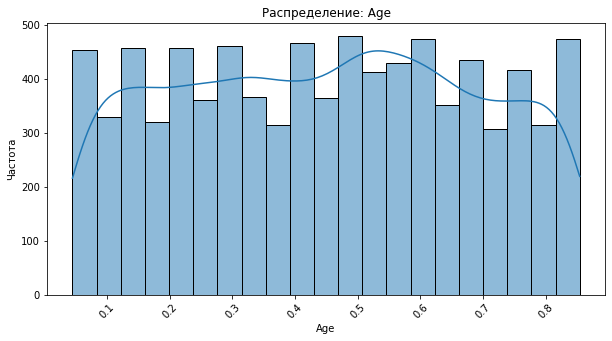

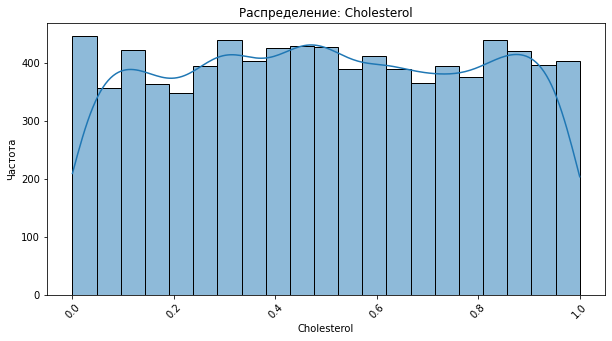

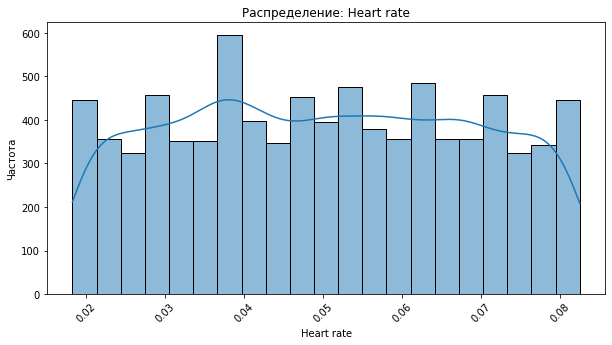

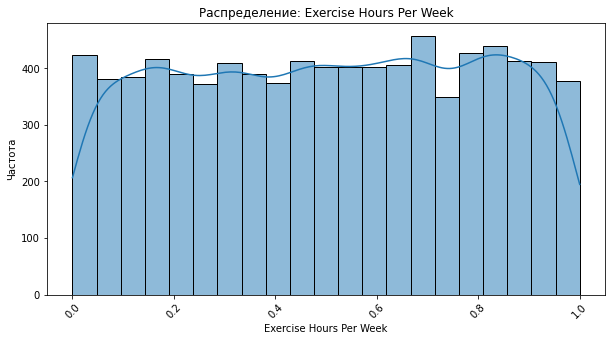

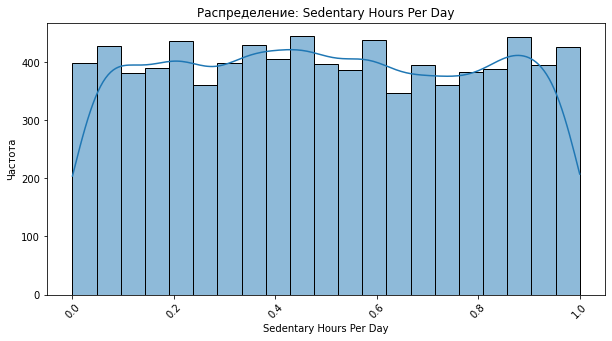

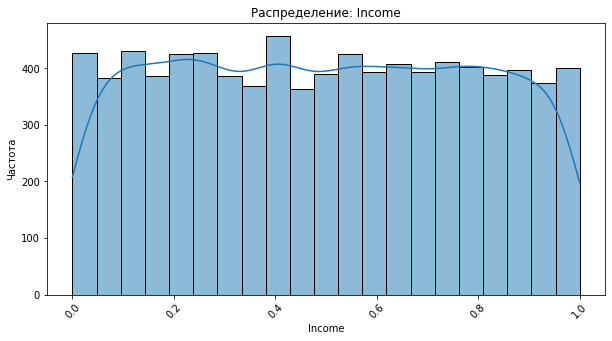

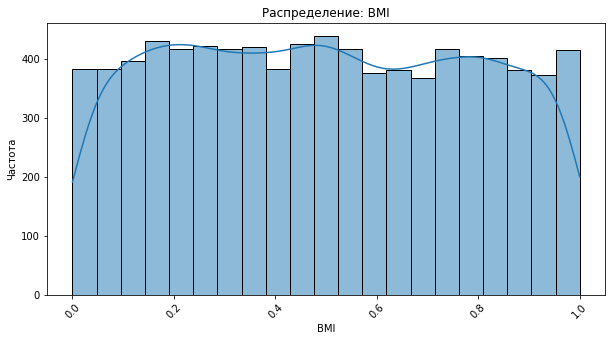

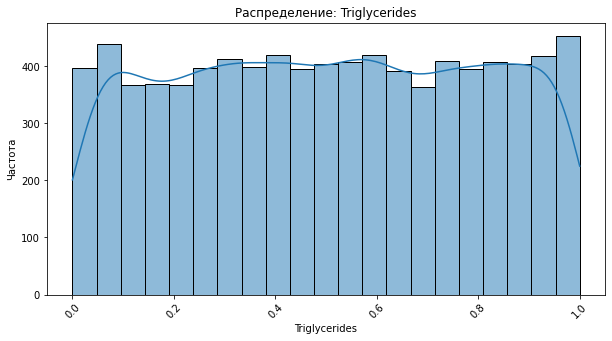

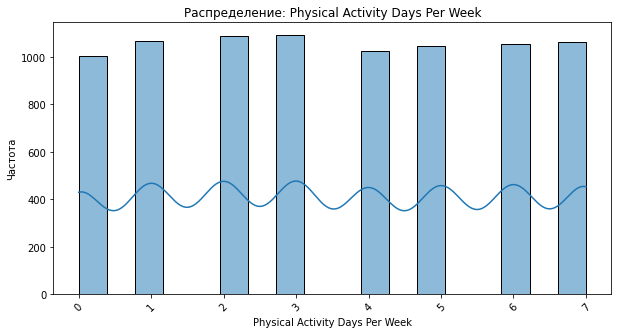

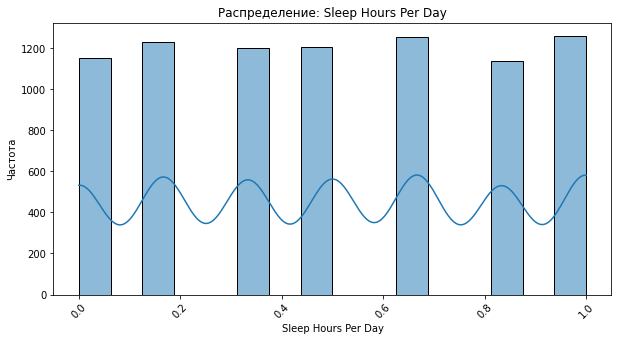

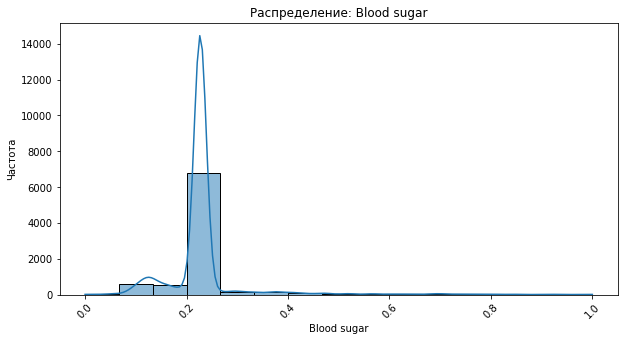

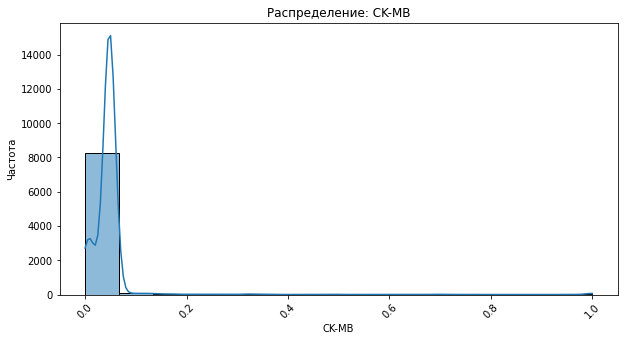

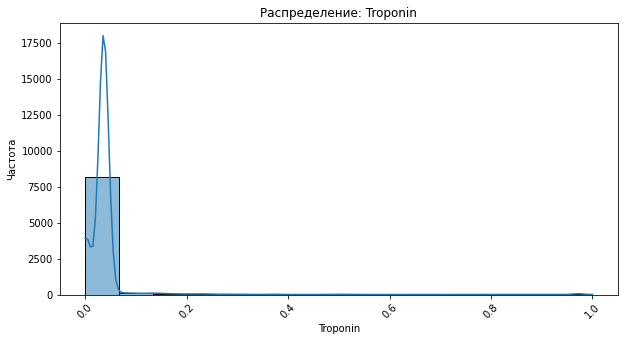

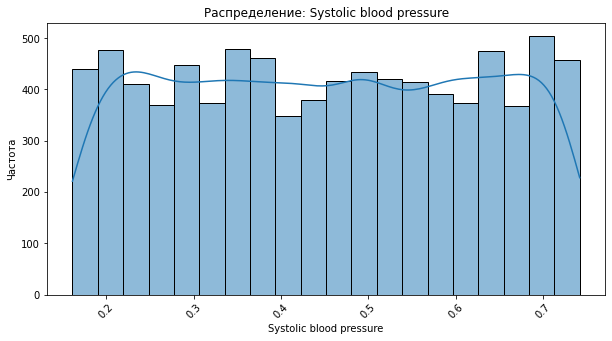

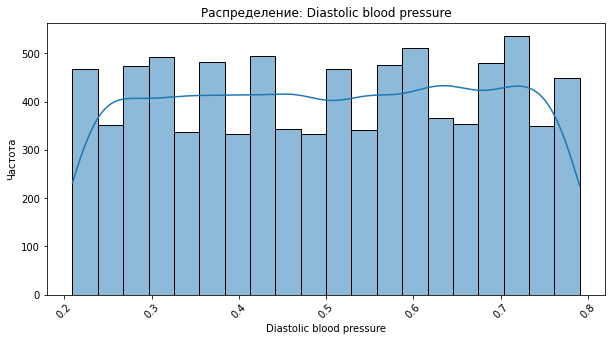

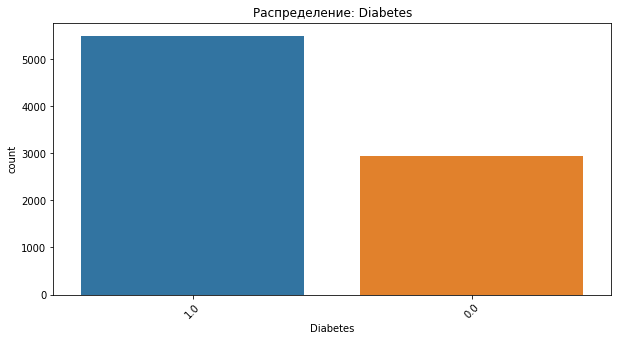

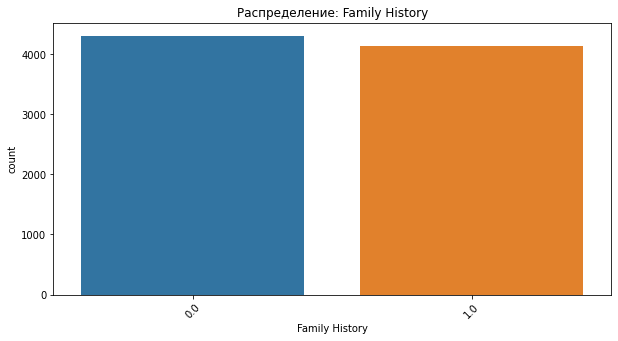

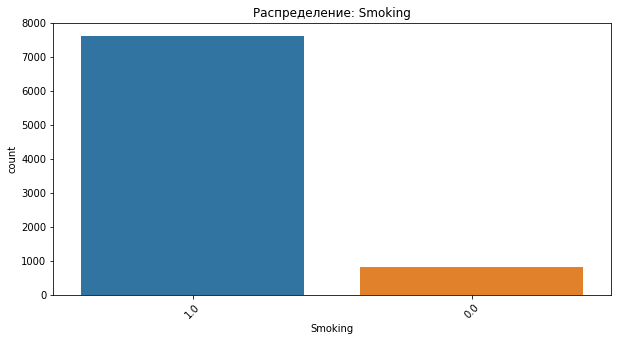

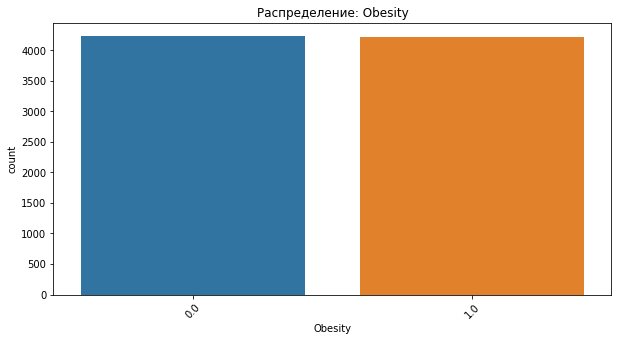

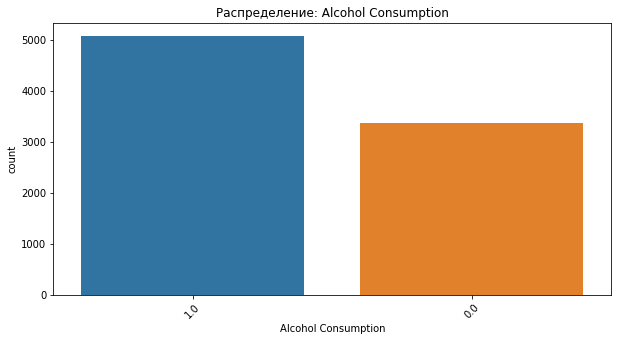

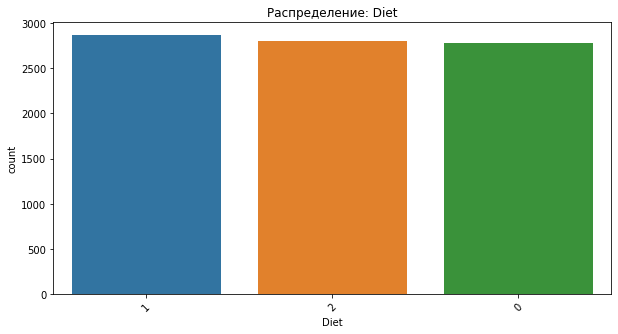

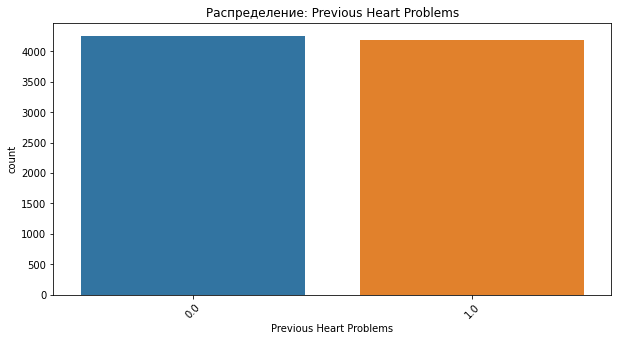

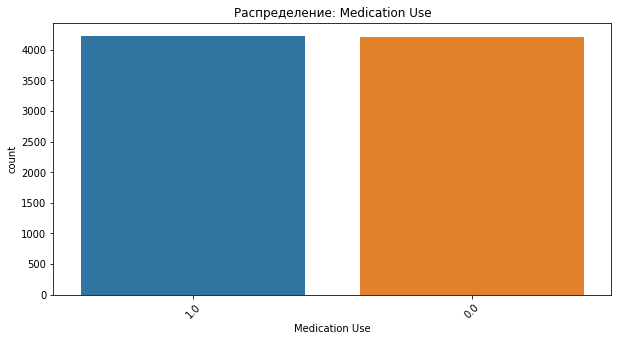

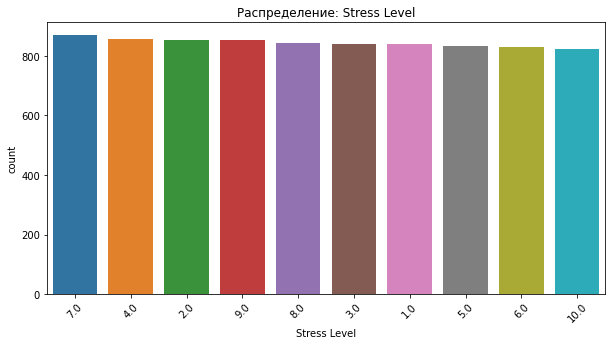

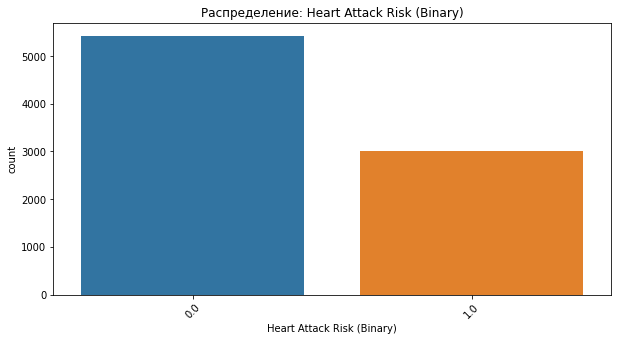

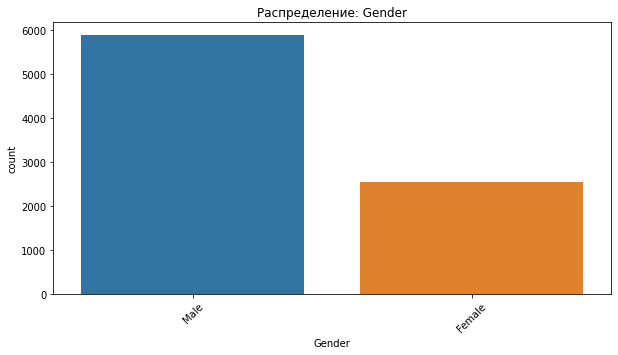

In [26]:
for col in num_cols:
        plt.figure(figsize=(10, 5))
        sns.histplot(df_train[col], kde=True)
        plt.title(f'Распределение: {col}')
        plt.xlabel(col)
        plt.ylabel('Частота')
        plt.xticks(rotation=45)
        plt.show()

for col in cat_cols:
            plt.figure(figsize=(10, 5))
            sns.countplot(x=col, data=df_train, order=df_train[col].value_counts().index)
            plt.title(f'Распределение: {col}')
            plt.xticks(rotation=45)
            plt.show()

Из общего фона выделяется график Blood sugar, CK-MB, Troponin, Heart Rate поэтому предлагаю изучить их чуть детальнее

In [27]:
df_train['Blood sugar'].describe()

count    8442.000000
mean        0.227998
std         0.074623
min         0.000000
25%         0.227018
50%         0.227018
75%         0.227018
max         1.000000
Name: Blood sugar, dtype: float64

По описанию данных видно, что максимальное значение превышает 3 квантиль почти в 4 раза. 

In [28]:
df_train['Blood sugar'].sort_values().tail(20)

2209    0.782609
6600    0.782609
6077    0.782609
3043    0.806324
101     0.806324
3659    0.806324
6856    0.806324
8231    0.806324
7795    0.806324
7753    0.843874
4964    0.843874
6596    0.843874
7840    0.843874
4167    0.843874
5008    0.918972
2730    0.918972
5182    0.918972
7223    0.918972
5590    1.000000
4305    1.000000
Name: Blood sugar, dtype: float64

Как бы можно было бы зафильтрофать до значения 0.5-0.7, но:

С одной стороны для стандартного МО выбросы необходимо удалять, чтобы оставлять нормально распределенные данные, которые описывают необходимый целевой признак.

С другой стороны, если попробовать проанализировать ситуацию предсказания риска сердечного приступа, то по сути люди с таким заболеванием в общей выборке сами по себе могут быть как выбросы.

Если посмотреть с медицинской точки зрения, то высокий уровень сахара в крови один из факторов риска инфаркта, потому если исключить эти данные, предсказательная способность модели может упасть.

Из этого следует вывод, что удалять такие данные нельзя. 

Посмотрим другие: CK-MB, Troponin, Heart Rate

In [29]:
df_train['CK-MB'].describe()

count    8442.000000
mean        0.047745
std         0.070399
min         0.000000
25%         0.048229
50%         0.048229
75%         0.048229
max         1.000000
Name: CK-MB, dtype: float64

In [30]:
df_train['Troponin'].describe()

count    8442.000000
mean        0.036867
std         0.059284
min         0.000000
25%         0.036512
50%         0.036512
75%         0.036512
max         1.000000
Name: Troponin, dtype: float64

Эти признаки мы очевидно не тронем, так как они являются целевыми

In [31]:
df_train['Heart rate'].describe()

count    8442.000000
mean        0.050194
std         0.018442
min         0.018332
25%         0.034830
50%         0.050412
75%         0.065995
max         0.082493
Name: Heart rate, dtype: float64

In [32]:
df_train['Heart rate'].sort_values().tail()

4304    0.082493
2745    0.082493
467     0.082493
3282    0.082493
6964    0.082493
Name: Heart rate, dtype: float64

In [33]:
df_test['Heart rate'].sort_values().tail()

816    0.082493
279    0.082493
393    0.082493
246    0.082493
183    0.082493
Name: Heart rate, dtype: float64

C пульсом удалим эти 3 выброса

In [34]:
#df_train = df_train.drop(index = [1377,2712]) - до удалению пропусков значения по индексами были с выбросами

In [35]:
#df_test = df_test.drop(index = [456]) - до удалению пропусков значения по индексами были с выбросами

In [36]:
df_train['Heart rate'].sort_values().tail()

4304    0.082493
2745    0.082493
467     0.082493
3282    0.082493
6964    0.082493
Name: Heart rate, dtype: float64

In [37]:
df_test['Heart rate'].sort_values().tail()

816    0.082493
279    0.082493
393    0.082493
246    0.082493
183    0.082493
Name: Heart rate, dtype: float64

В гендере завалялись два значения 0 и 1, отличных от общих наименований. 

In [38]:
#df_train['Gender'] = df_train['Gender'].replace({'0.0': 'Female', '1.0': 'Male'})

In [39]:
df_train['Gender'].value_counts()

Male      5882
Female    2560
Name: Gender, dtype: int64

In [40]:
#df_test['Gender'] = df_test['Gender'].replace({'0.0': 'Female', '1.0': 'Male'}) - до удалению пропусков были закодированные значения

In [41]:
df_test['Gender'].value_counts()

Male      650
Female    285
Name: Gender, dtype: int64

### Строим матрицу корреляции

In [42]:
corr_phik = df_train.drop('id', axis = 1).phik_matrix(interval_cols=num_cols)

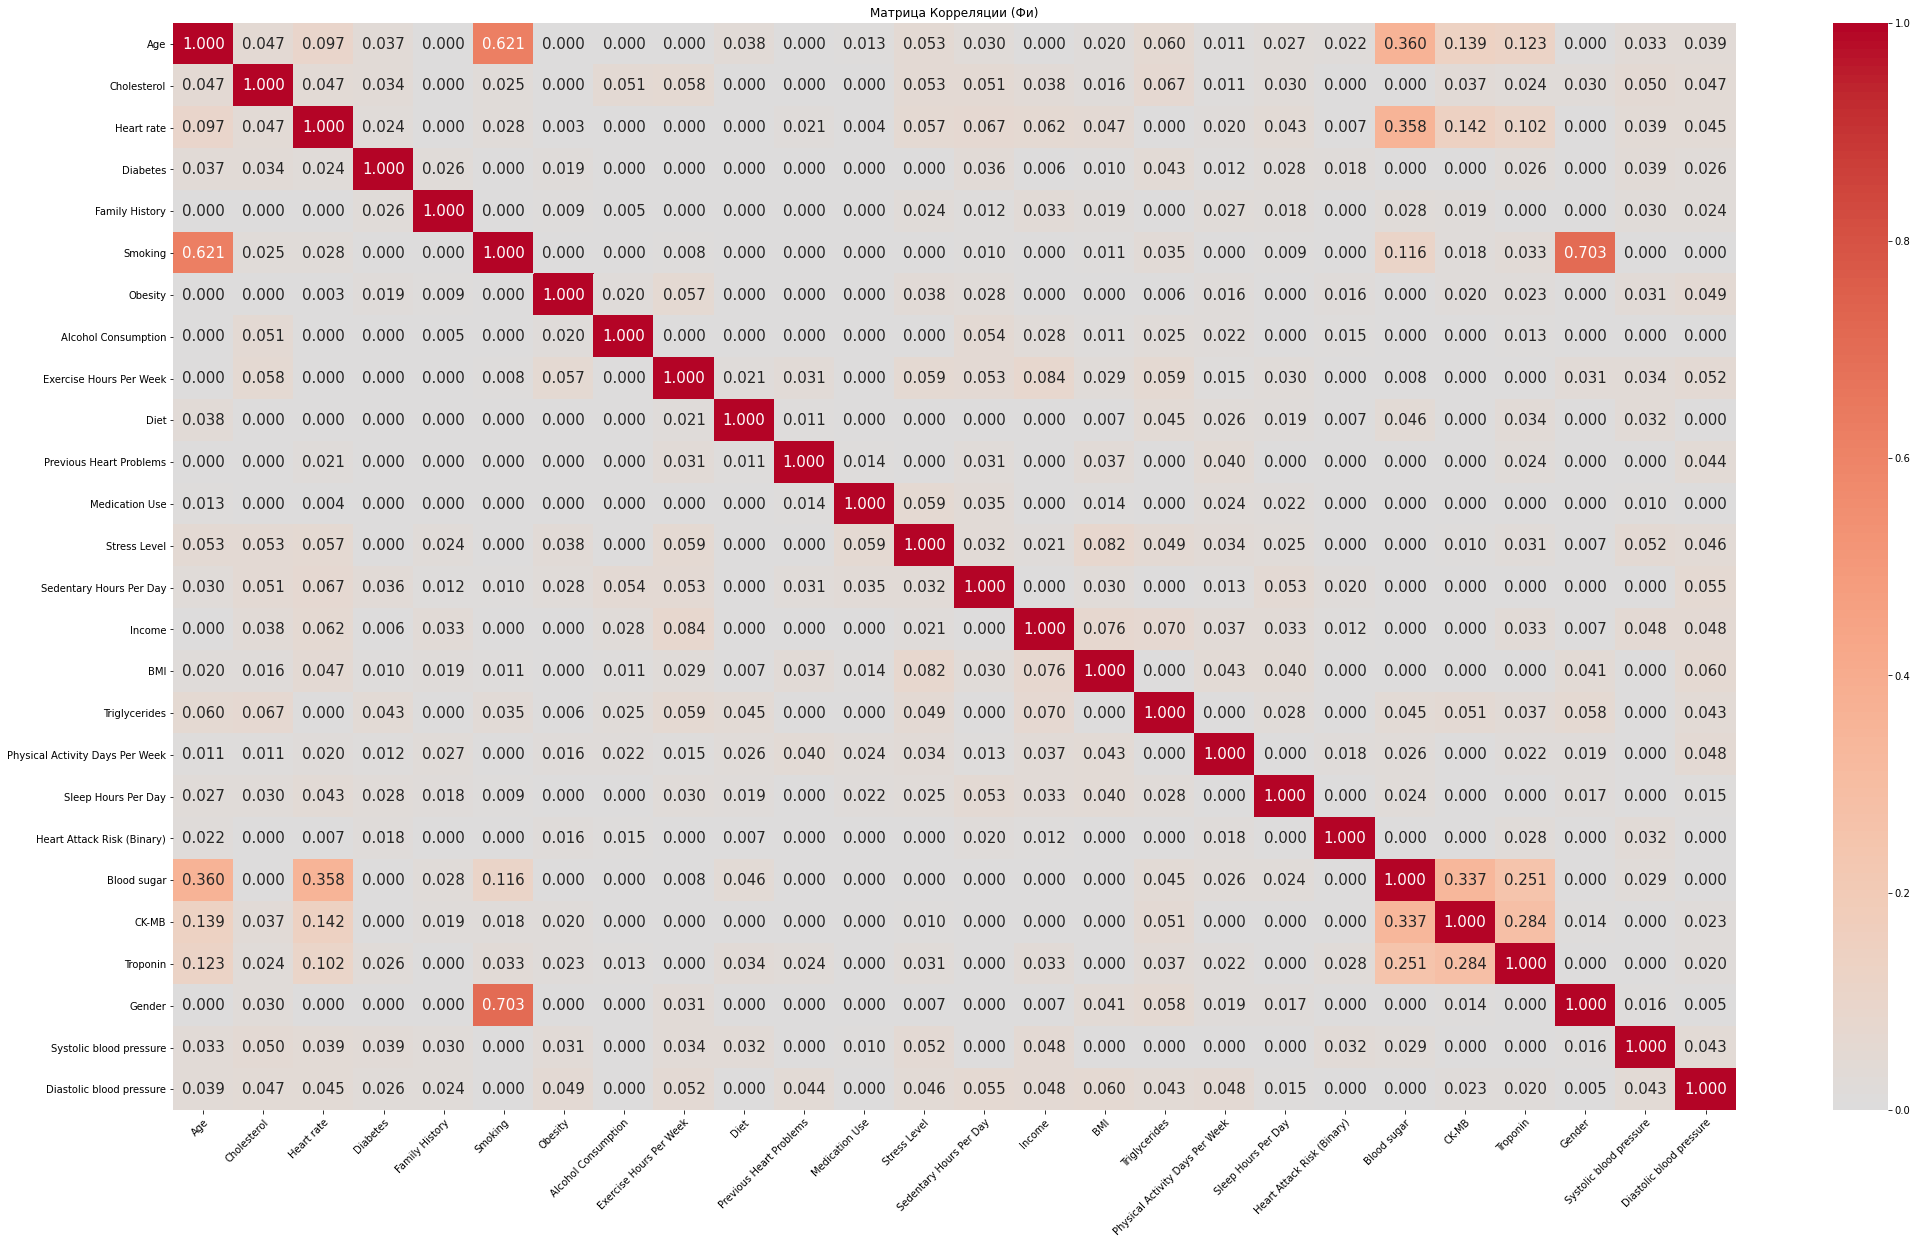

In [43]:
plt.figure(figsize=(35, 20))
ax = sns.heatmap(corr_phik, annot=True, cmap='coolwarm', center=0, annot_kws={'size': 15}, fmt='.3f')
plt.title('Матрица Корреляции (Фи)')

ax.set_xticklabels(ax.get_xticklabels(),
                      rotation=45,
                      ha='right',
                      rotation_mode='anchor')

plt.show()

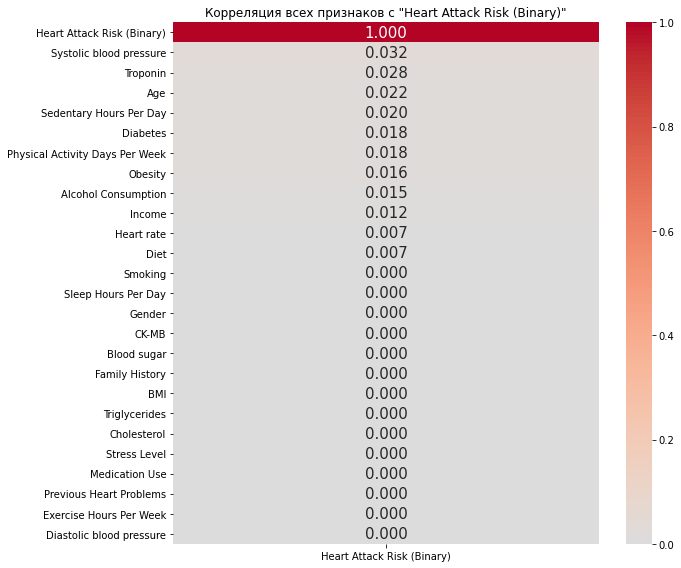

In [44]:
target_column = 'Heart Attack Risk (Binary)'
corr_with_target = corr_phik[[target_column]].sort_values(by=target_column, ascending=False)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(corr_with_target, annot=True, cmap='coolwarm', center=0, 
                 annot_kws={'size': 15}, fmt='.3f')
plt.title(f'Корреляция всех признаков с "{target_column}"')

plt.tight_layout()
plt.show()

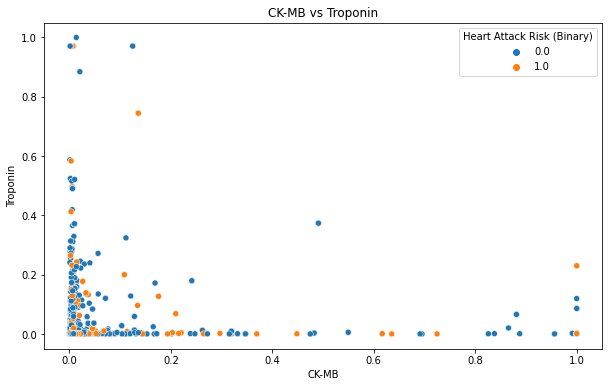

In [45]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_train, x='CK-MB', y='Troponin', hue='Heart Attack Risk (Binary)') # если есть метка инфаркта
plt.title('CK-MB vs Troponin')
plt.show()

Ожидал что целевой признак будет сильно коррелировать с тропонином и CK-MB, однако ни на матрице, ни на диаграмме рассеяния связей не видно. В любом случае, выводов о их удалении это не меняет, иначе будет утечка.

Таким образом можно подумать об удалении признаков:

    1. CK-MB - утечка целевого
    2. Troponin - утечка целевого
    3. Income - бесполезный признак (его влияние не целевой очень опосредовано, например через лучший доступ к медецине, качеству питания, уровню стресса)
    4. Obesity - фактически дублирует ИМТ (BMI)
    5. Physical Activity Days Per Week - дублирует количество часов физической активности

## Пайплайн

### Экспериментирую с добавлением признаков:

У нас есть 2 признака о физической активности: 
* Exercise Hours Per Week	- количество часов физических упражнений в неделю
* Physical Activity Days Per Week	- физическая активность в неделю (в днях)

По сути для здоровья важна как и количество физической активности так и ее частота. Поэтому мне кажется если перемножить эти признаки, то получится 1 более информативный (не читаемый для человека, но важный для целевого признака, а значит и для предсказания)

### Удаляем признаки

In [46]:
f_drop =['id', 'CK-MB','Troponin', 'Income', 'Obesity', 'Physical Activity Days Per Week']

In [47]:
df_test_id = df_test['id'] # сохраняем id чтобы затем сделать csv с предсказаниями конкретным пользователям

In [48]:
df_train = df_train.drop(f_drop, axis = 1)

In [49]:
df_test = df_test.drop(f_drop, axis = 1)

### Разделение данных

In [50]:
X_train, X_valid, y_train, y_valid = train_test_split(
    df_train.drop('Heart Attack Risk (Binary)', axis=1),
    df_train['Heart Attack Risk (Binary)'],
    test_size = VALID_SIZE,
    random_state = RANDOM_STATE,
    stratify = df_train['Heart Attack Risk (Binary)'])

In [51]:
X_train.to_csv('API_test.csv', index=False) # для тестирования предсказаний на FastAPI 

### Списки столбцов для кодирования, масштабирования

"Для приведения данных к единому формату в пайплайне надо закодировать пол и диету Lebel Encoder и One-Hot En., так как между данными нет логичного порядка, уровень стресса через Ordinal Encoder (можно потом попробовать перевести в числовой и масштабировать), так как их можно выстроить в логичный порядок. Количество физической активности в днях в неделю переведем в числовой и масштабируем или удалим, так как он дублирует количество активности в часах."

In [52]:
exclude_list = ['CK-MB','Troponin', 'Income', 'Physical Activity Days Per Week']

In [53]:
num_cols = [col for col in num_cols if col not in exclude_list]

In [54]:
num_cols

['Age',
 'Cholesterol',
 'Heart rate',
 'Exercise Hours Per Week',
 'Sedentary Hours Per Day',
 'BMI',
 'Triglycerides',
 'Sleep Hours Per Day',
 'Blood sugar',
 'Systolic blood pressure',
 'Diastolic blood pressure']

In [55]:
ohe_cols = ['Gender','Diet']
ord_cols = ['Stress Level']

In [56]:
df_train[ord_cols].value_counts().sort_index(level='Stress Level')

Stress Level
1.0             840
2.0             854
3.0             841
4.0             857
5.0             833
6.0             828
7.0             869
8.0             844
9.0             852
10.0            824
dtype: int64

### Сами пайплайны

#### пайплайн для подготовки признаков из списка ohe_cols: заполнение пропусков и OHE-кодирование SimpleImputer + OHE (пропусков заранее удалены, но для стабильности работы пайплайна все равно будет)

In [57]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False, ))
    ]
)
# в случае конфликта версий библиотек заменить sparse=False на sparse_output=False
# в случае использования drop='first' возникает конфликт (на этапе уже обучения модели), так как предварительно данная версия OHE не работает с handle_unknown='ignore' (вместо 'error'). 


#### пайплайн для подготовки признаков из списка ord_col: заполнение пропусков и Ordinal-кодирование SimpleImputer + OE

In [58]:
unique_stress_levels = sorted(df_train['Stress Level'].unique()) # порядок категорий для Ordinal encoder

In [59]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
     ('ord',  OrdinalEncoder(
                categories=[
                    unique_stress_levels,
                ],
                handle_unknown='use_encoded_value', unknown_value=np.nan
            )
        ),
     ('simpleImputer_after_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
    ]
)

#### общий пайплайн для подготовки признаков: 1) из списка ohe_cols: заполнение пропусков и OneHot-кодирование   2) из списка ord_col: заполнение пропусков и Ordinal-кодирование SimpleImputer + OE

In [60]:
data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_cols),
     ('ord', ord_pipe, ord_cols)
    ],
    remainder='passthrough'
) 

# ,
#     ('num', MinMaxScaler(), num_cols) - вставить в случае необходиомсти масштабировать данные



#### Итоговый пайплайн: подготовка данных и модели

In [61]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

### модели и их гиперпараметры

param_grid = [
    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2,15),
        'models__max_features': range(2,15)
    },

    # словарь для модели KNeighborsClassifier()
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2,10)
    },

    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1,8)
    },
    {
        'models': [SVC(
            random_state=RANDOM_STATE, probability=True
        )],
        'models__degree': range(3,7)
    },
    {
        'models': [CatBoostClassifier(
            random_state=RANDOM_STATE,
            verbose=False,  # Отключаем вывод логов
            auto_class_weights='Balanced',
            # Отключаем обработку категориальных признаков
            cat_features=None,  # Явно указываем, что категориальных признаков нет
            bootstrap_type='Bernoulli'  # Для ускорения обучения
        )],
        'models__depth': [4, 6, 8],           # Глубина деревьев
        'models__learning_rate': [0.01, 0.1], # Скорость обучения
        'models__iterations': [100, 200],     # Количество деревьев
        'models__l2_leaf_reg': [1, 3]         # Регуляризация
    }
    
]

# в случае необходимости масштабирования или стандартизации добавить к каждой модели этап preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']

In [62]:
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

param_grid = [
    # Decision Tree
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [3,5,7,9,12,15, None],
        'models__min_samples_split': [2,5,10,20],
        'models__min_samples_leaf': [1,3,5,10],
        'models__max_features': [None, 'sqrt', 'log2']
    },

    # Logistic Regression (sanity strong baseline)
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='saga',
            penalty='l1',
            class_weight='balanced',
            max_iter=5000
        )],
        'models__C': [0.1, 0.5, 1, 2, 5]
    },

    # SVC (RBF) с калибровкой вероятностей
    {
        'models': [CalibratedClassifierCV(
            estimator=SVC(kernel='rbf', class_weight='balanced', probability=False, random_state=RANDOM_STATE),
            method='isotonic',  # более стабильна, чем Platt, если выборка позволяет
            cv=3
        )],
        'models__base_estimator__C': [0.5, 1, 2, 4],
        'models__base_estimator__gamma': ['scale', 0.5, 1]
    },

    # CatBoost — расширяем итерации и включаем раннюю остановку
    {
        'models': [CatBoostClassifier(
            random_state=RANDOM_STATE,
            verbose=False,
            auto_class_weights='Balanced',
            # cat_features=None — уже после препроцессинга всё численно, это ок
        )],
        'models__depth': [4, 6, 8],
        'models__learning_rate': [0.02, 0.05, 0.1],
        'models__l2_leaf_reg': [3, 10, 20],
        'models__iterations': [1500, 2500],   # ВАЖНО: больше деревьев
        # раннюю остановку зададим через fit_params (см. ниже)
    },
]

### Тестрирование модели и метрики

In [63]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [64]:
start_time = time.time()

random_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    n_iter=50 
)
random_search.fit(X_train, y_train)

end_time = time.time()
total_time = end_time - start_time
print(f"Время подбора гиперпараметров: {total_time:.2f} секунд")

print('Лучшая модель и её параметры:\n\n', random_search.best_estimator_)
print ('Метрика лучшей модели на тренировочной выборке:', random_search.best_score_)



Время подбора гиперпараметров: 355.77 секунд
Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Gender', 'Diet']),
                                                 ('ord',
                                                  Pipeline(steps=[(

In [65]:
ct = random_search.best_estimator_.named_steps['preprocessor']
print(ct.feature_names_in_)

['Age' 'Cholesterol' 'Heart rate' 'Diabetes' 'Family History' 'Smoking'
 'Alcohol Consumption' 'Exercise Hours Per Week' 'Diet'
 'Previous Heart Problems' 'Medication Use' 'Stress Level'
 'Sedentary Hours Per Day' 'BMI' 'Triglycerides' 'Sleep Hours Per Day'
 'Blood sugar' 'Gender' 'Systolic blood pressure'
 'Diastolic blood pressure']


In [66]:
# проверьте работу модели на тестовой выборке
# рассчитайте прогноз на тестовых данных
y_valid_pred = random_search.best_estimator_.predict_proba(X_valid)[:,1]
print(f'Метрика ROC-AUC на тестовой выборке: {roc_auc_score(y_valid, y_valid_pred)}')

Метрика ROC-AUC на тестовой выборке: 0.5798093829884194


In [67]:
y_valid_pred = random_search.best_estimator_.predict(X_valid)
print(f'Метрика accuracy на тестовой выборке: {accuracy_score(y_valid, y_valid_pred)}')

Метрика accuracy на тестовой выборке: 0.6063477025106585


In [68]:
y_valid_pred = random_search.best_estimator_.predict(X_valid)
print(f'Метрика f1 на валидационной выборке: {f1_score(y_valid, y_valid_pred)}')

Метрика f1 на валидационной выборке: 0.330378726833199


## Анализ важности признаков

## Здесь планируется дальнейшая инженерия признаков, удаление и добавления в соответствии с важностью первоначальных признаков, добавление полиномиальных признаков...

## Здесь планируется пайплайн с лучшей моделью, перебором по сетке ее гиперпараметров...

## Завершающий этап. Предсказание на тестовых данных лучшей моделью и сохранение их в отдельный файл.

### предсказание и сохранение

In [69]:
y_pred = random_search.best_estimator_.predict(df_test)

In [70]:
pred_csv= pd.DataFrame(
    {
    'id': df_test_id, # Берем исходные id из тестового файла
    'prediction': y_pred
    }
)

In [71]:
pred_csv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 935 entries, 0 to 965
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          935 non-null    int64  
 1   prediction  935 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 21.9 KB


In [72]:
pred_csv.to_csv('pred_test.csv', index=False)

### сохранение обученной модели в отдельный файл

In [73]:
joblib.dump(random_search.best_estimator_, 'model_heart_risk.pkl')

['model_heart_risk.pkl']